In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import SimpleITK as sitk
import sys
from scipy.ndimage import find_objects
%load_ext autoreload
%autoreload 2
#sys.path.append('../')
#from data_scripts.PI_CAI_Detection import PI_CAI_Detection
from radiomics_util import *

/u/home/seel/.conda/envs/conda-adlm/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
gt = pd.read_csv("/data1/practical-sose23/morphometric/picai_labels/clinical_information/marksheet.csv")
gt.head()

patient_id  study_id    mri_date  patient_age   psa  psad  prostate_volume  \
0       10000   1000000  2019-07-02           73   7.7   NaN             55.0   
1       10001   1000001  2016-05-27           64   8.7  0.09            102.0   
2       10002   1000002  2021-04-18           58   4.2  0.06             74.0   
3       10003   1000003  2019-04-05           72  13.0   NaN             71.5   
4       10004   1000004  2020-10-21           67   8.0  0.10             78.0   

  histopath_type lesion_GS lesion_ISUP  case_ISUP case_csPCa  
0           MRBx       0+0           0          0         NO  
1            NaN       NaN         NaN          0         NO  
2            NaN       NaN         NaN          0         NO  
3          SysBx       0+0           0          0         NO  
4     SysBx+MRBx   0+0,0+0         0,0          0         NO

In [3]:
def crop(image, mask, crop_size):
    crop_size = np.asarray(crop_size)
    array = sitk.GetArrayFromImage(mask)
    bounding_box = find_objects(array)[0]
    center = np.asarray([
        bounding_box[2].stop - (bounding_box[2].stop - bounding_box[2].start)/2,
        bounding_box[1].stop - (bounding_box[1].stop - bounding_box[1].start)/2,
        
        bounding_box[0].stop - (bounding_box[0].stop - bounding_box[0].start)/2,
    ]).astype(int)
    
    #print("center:",center)
    lower_bounds = center - crop_size//2
    upper_bounds = center + crop_size//2
    lower_bounds = np.maximum(lower_bounds, 0).astype(int)
    #print("crop_size:", crop_size)
    #print("lower_bounds:", lower_bounds)
    
    
    adjusted_crop = np.minimum(crop_size, array.T.shape-lower_bounds)
    #print("adjusted_crop:", adjusted_crop)

    cropped_image = sitk.RegionOfInterest(image, adjusted_crop.tolist(), lower_bounds.tolist())
    cropped_mask = sitk.RegionOfInterest(mask  , adjusted_crop.tolist(), lower_bounds.tolist())

    padding = crop_size - np.array(cropped_image.GetSize())
    #print("padding:",padding)

    expanded_image = sitk.ConstantPad(cropped_image, padding.tolist(), (0, 0, 0))
    expanded_mask = sitk.ConstantPad(cropped_mask  , padding.tolist(), (0, 0, 0))
    return expanded_image, expanded_mask



0
(34, 180, 180)
(34, 180, 180)
1
(25, 192, 192)
(25, 192, 192)
2
(22, 192, 192)
(22, 192, 192)


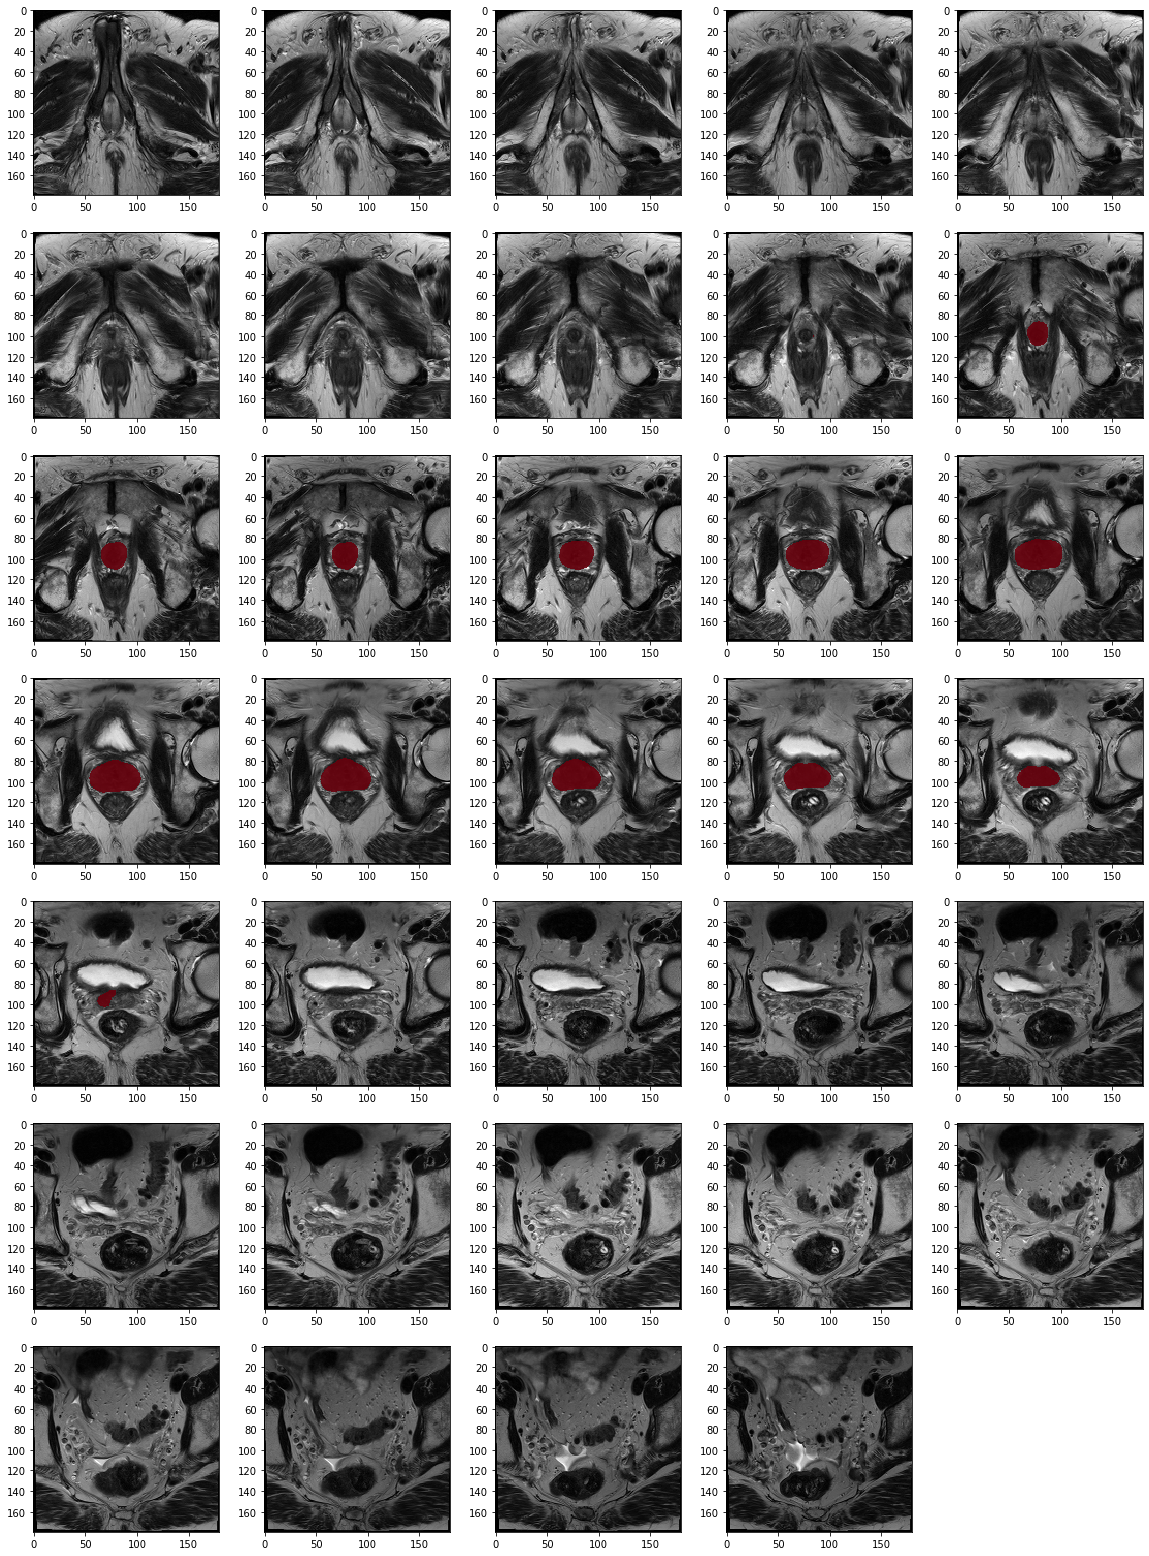

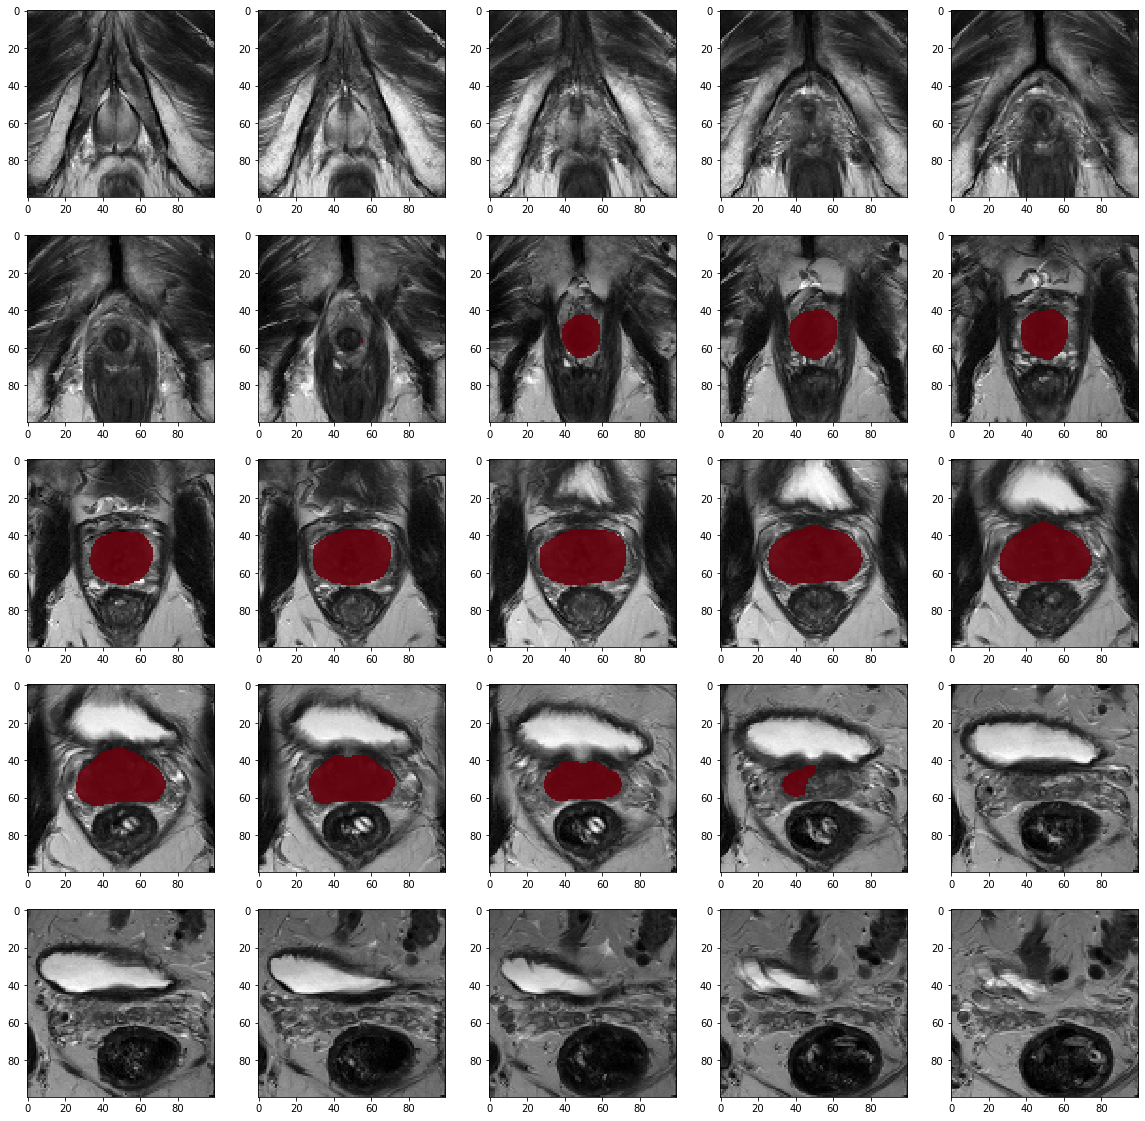

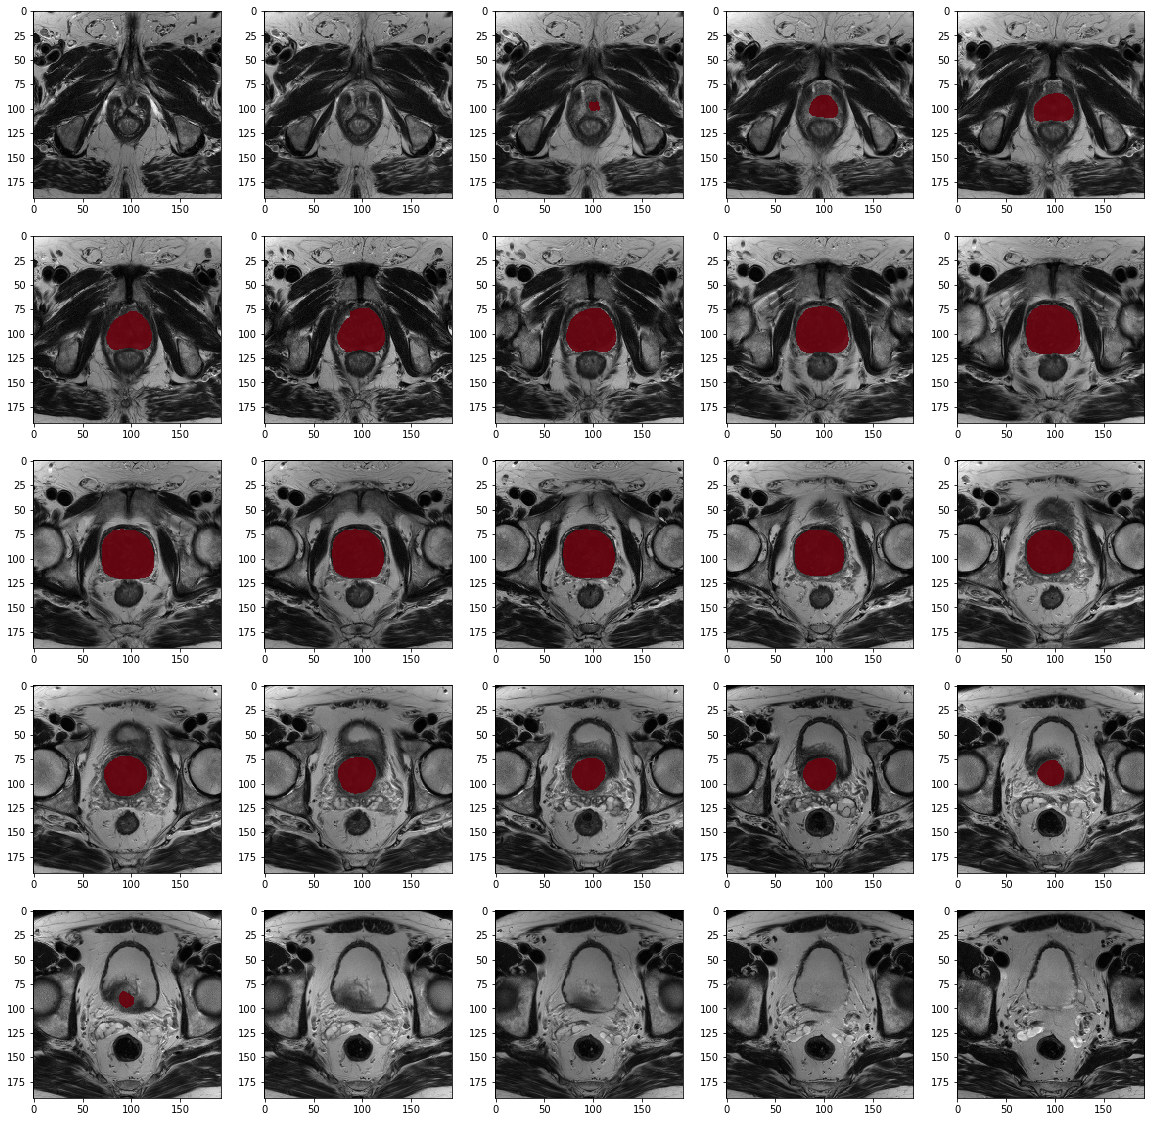

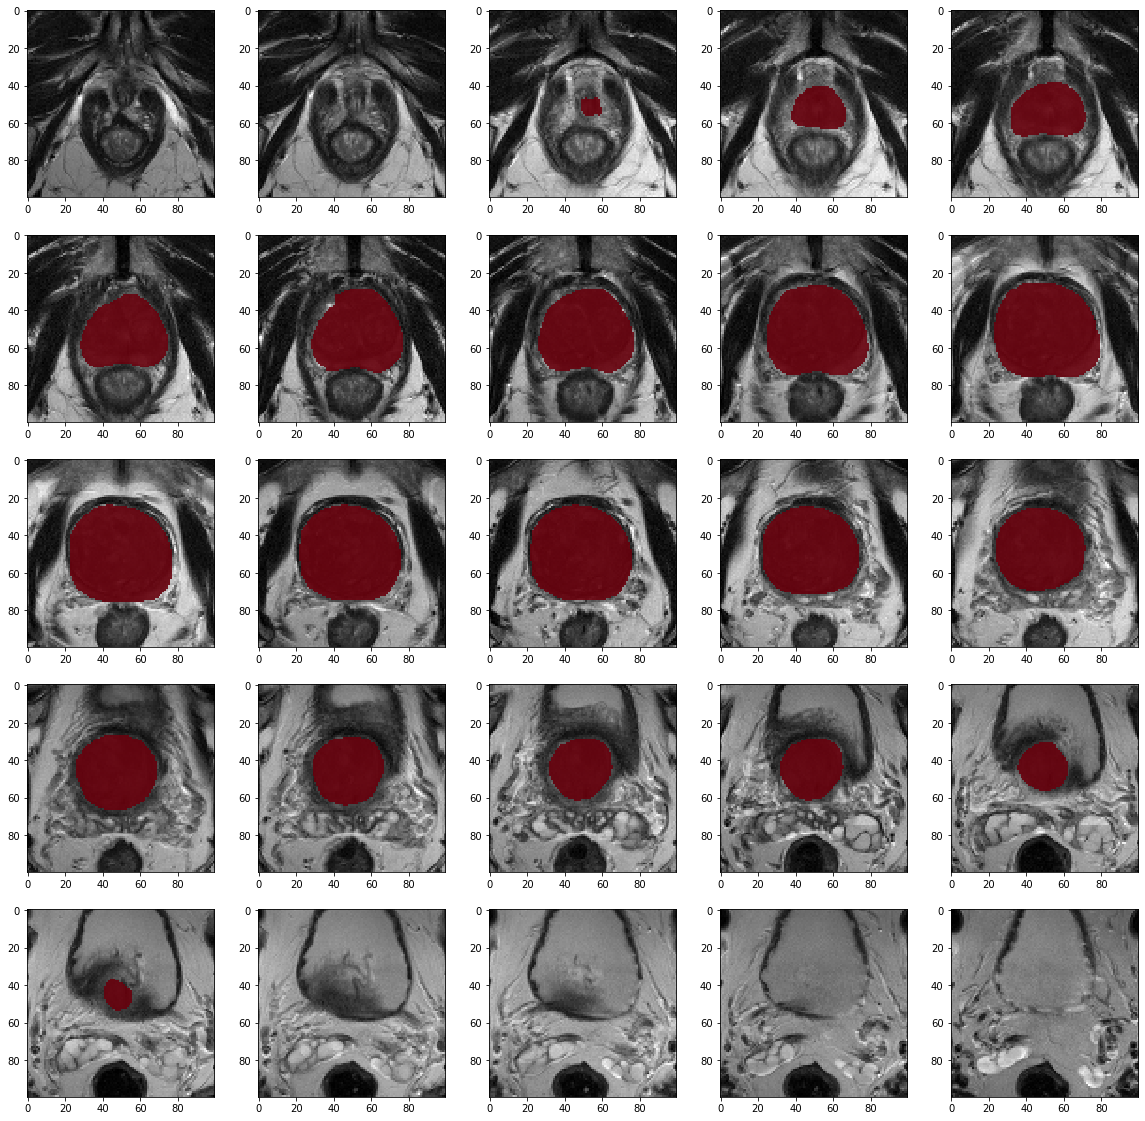

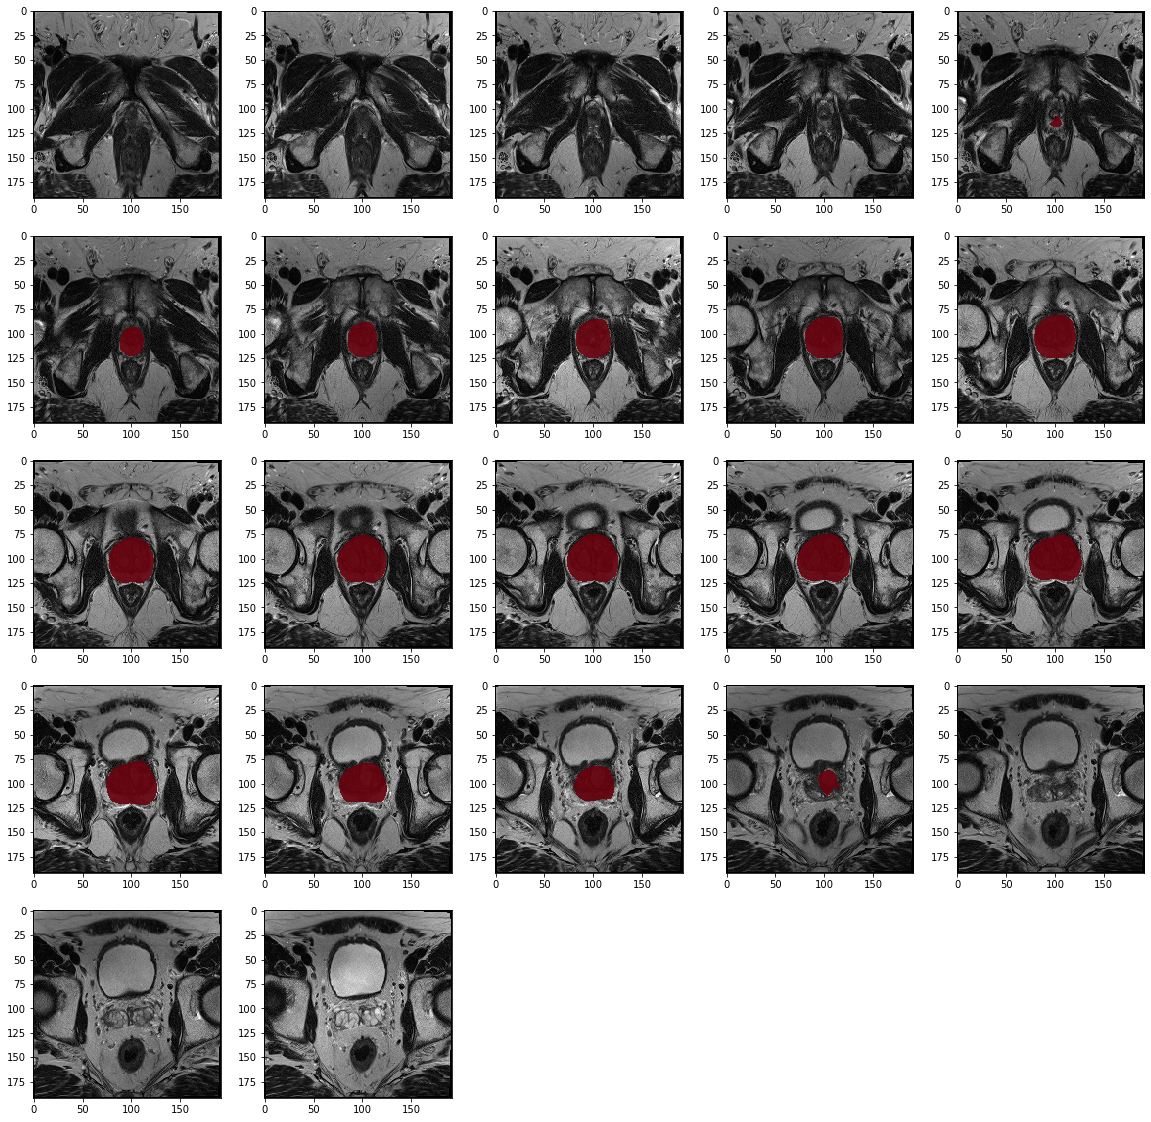

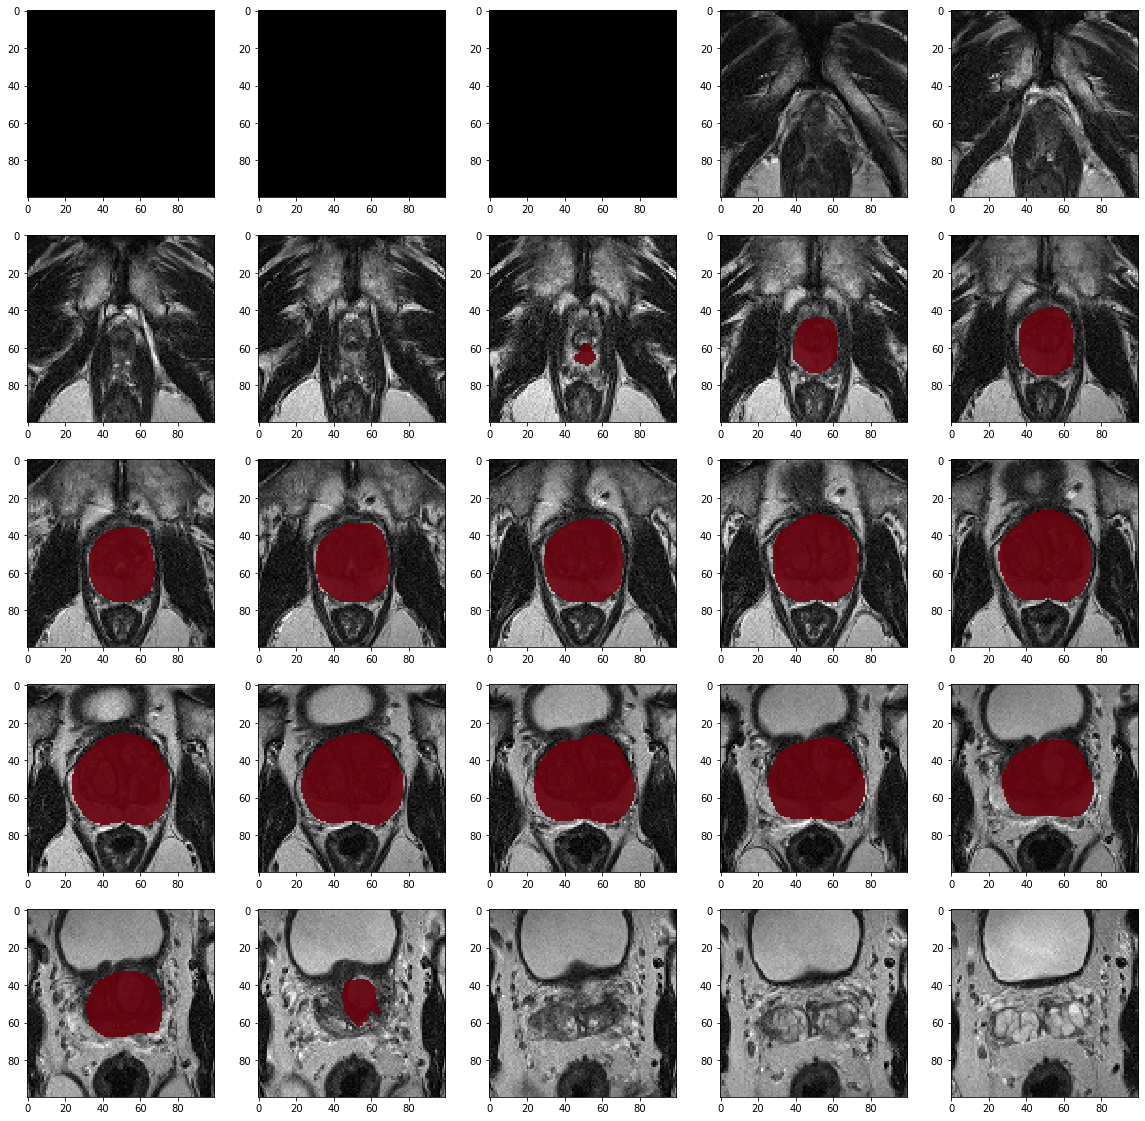

In [5]:

for i, row in gt.head(3).iterrows():
    print(i)
    image, mask = get_image_and_segmentaion(int(row["patient_id"]), int(row["study_id"]))

    print(sitk.GetArrayFromImage(image).shape)
    print(sitk.GetArrayFromImage(mask).shape)

    plot_sitk(image, mask)
    ci, cm = crop(image, mask, (100,100,25))
    plot_sitk(ci,cm)

In [7]:
data_path = "/data1/practical-sose23/morphometric/data_cropped/"
seg_guer_path = "/data1/practical-sose23/morphometric/picai_labels_cropped/anatomical_delineations/whole_gland/AI/Guerbet23/"
for i, row in gt.iterrows():
    print(i)
    image, mask = get_image_and_segmentaion(int(row["patient_id"]), int(row["study_id"]))

    #print(sitk.GetArrayFromImage(image).shape)
    #print(sitk.GetArrayFromImage(mask).shape)

    #plot_sitk(image, mask)
    ci, cm = crop(image, mask, (100,100,25))
    #plot_sitk(ci,cm)

    modality = "t2w"
    file = "{0}_{1}_{2}.mha".format(str(int(row["patient_id"])),str(int(row["study_id"])), modality)

    writer = sitk.ImageFileWriter()
    writer.SetFileName(data_path + str(int(row["patient_id"])) + "/" +  file)
    writer.Execute(ci)

    file = "{0}_{1}.nii.gz".format(str(int(row["patient_id"])),str(int(row["study_id"])))
    writer = sitk.ImageFileWriter()
    writer.SetFileName(seg_guer_path + file)
    writer.Execute(cm)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27